In [1]:
import pandas as pd
import numpy as np
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

warnings.filterwarnings("ignore")
np.random.seed(42)

In [2]:
from yellowbrick.classifier import ClassificationReport

In [3]:
grid_search_enable = True
cv = 2
verbose = 3
number_of_jobs = -1
rand_state = 101
test_size = 0.4

In [4]:
bdf = pd.read_csv("featured_bank_imputed_wo_duration_year.csv")

### Feature engineering

In [5]:
def festivals(month):
    # imputing festivals - apr: easter; jun:carnival; dec:christmas
    if month == 'apr' or month == 'jun' or month == 'dec':
        return 1
    else:
        return 0

In [6]:
bdf['f.festivals'] = bdf['month'].apply(festivals)

In [7]:
def bonus_months(month):
    # bonus paid twice in a year - may and nov
    if month == 'jun' or month == 'dec':
        return 1
    else:
        return 0

In [8]:
bdf['f.bonus_months']= bdf['month'].apply(bonus_months)

In [9]:
def commitment(housing, personal, marital):
    # if a person is married and has housing and personal loans, flag it as high commitment
    if housing == 'yes' and personal == 'yes' and marital == 'married':
        return 'high'
    if housing == 'no' and personal == 'no' and marital in ['single']:
        return 'low'
    else:
        return 'medium'

In [10]:
bdf['f.commitment'] = bdf.apply(lambda x: commitment(x.housing, x.loan, x.marital), axis=1)

In [11]:
def seasons(month):
    if month in ['mar','apr','may']:
        return 'spring'
    if month in ['jun','jul','aug']:
        return 'summer'
    if month in ['sep','oct','nov']:
        return 'autumn'
    if month in ['dec','jan','feb']:
        return 'winter'

In [12]:
bdf['f.seasons'] = bdf['month'].apply(lambda mon: seasons(mon))

In [13]:
def seasons_weightage(season):
    if season == 'autumn':
        return 21
    if season == 'spring':
        return 36
    if season == 'summer':
        return 40
    if season == "winter":
        return 2

In [14]:
#bdf ['f.season_weight'] = bdf['f.seasons'].apply(lambda season: seasons_weightage(season))

In [15]:
def retired(age):
    if age >= 65:
        return 'retired'
    else:
        return 'not-retired'

In [16]:
bdf['f.retired_status'] = bdf['age'].apply(lambda age: retired(age))

In [17]:
def marital_weightage(marital):
    if marital == 'divorced':
        return 1
    if marital == 'single':
        return 35
    if marital == 'married':
        return 54

In [18]:
#bdf['f.marital_weightage'] = bdf['marital'].apply(lambda status: marital_weightage(status))

In [19]:
def age_weightage(age):
    if age == '11_to_20':
        return 0.01
    if age == '21_to_30':
        return 0.23
    if age == '31_to_40':
        return 0.34
    if age == '41_to_50':
        return 0.18
    if age == '51_to_60':
        return 0.14
    if age == '61_to_70':
        return 0.04
    if age == '71_to_80':
        return 0.03
    if age == '81_to_90':
        return 0.01
    if age == '91_to_100':
        return 0.00
        

In [20]:
#bdf['f.age_weightage'] = bdf['f.age'].apply(lambda age: age_weightage(age))

In [21]:
def previous_user(previous):
    if previous == 0:
        return 'new user'
    else:
        return 'existing user'

In [22]:
bdf['f.user_type'] = bdf['previous'].apply(lambda previous: previous_user(previous))

In [23]:
def previous_no_of_times(previous):
    # if a user is part of the previous campaign, bin them
    if previous == 0:
        return 'no previous'
    if previous >= 1 and previous <= 3:
        return '1_to_3'
    if previous > 3:
        return 'gt_3'
    

In [24]:
bdf['f.previous_campaigns'] = bdf['previous'].apply(lambda previous: previous_no_of_times(previous))

In [25]:
def current_campaign_calls(calls):
    # how many times a user is called
    if calls == 1:
        return 'once'
    if calls >= 2 and calls <= 3:
        return 'twice to thrice '
    if calls > 3 and calls <= 6:
        return 'four to six times'
    if calls >= 7 and calls <= 10:
        return 'seven to ten times'
    if calls > 10:
        return 'more than ten times'
    

In [26]:
bdf['f.current_campaign_calls'] = bdf['campaign'].apply(lambda calls: current_campaign_calls(calls))

In [27]:
def first_time_user_calls(previous, campaigns):
    # first time user - not a part of previous campaign
    # first time the user is speaking - what's the conversion rate
    if previous == 0:
        if campaigns == 1:
            return 'first time called'
        if campaigns >= 2 and campaigns <= 3:
            return 'called atleast twice'
        if campaigns > 3:
            return 'called atleast thrice'
        else:
            return 'more than thrice'
    else:
        return 'returning user'

In [28]:
bdf['f.first_time_user_calls'] = bdf.apply(lambda x: first_time_user_calls(x.previous, x.campaign), axis=1)

In [29]:
def savings_intention(job):
    if job in ['admin.','blue-collar','technician']:
        return 100
    elif job in ['retired','management','services']:
        return 50
    else:
        return 25

In [30]:
bdf['f.savings_intent_factor'] = bdf['job'].apply(lambda job: savings_intention(job))

In [31]:
def age_range_weightage(age):
    if age <= 24:
        return 0.15
    if age >=25 and age <= 69:
        return 0.61
    if age >= 70 and age <= 80:
        return 0.13
    if age > 80:
        return 0.04

In [32]:
bdf['f.age_range_weightage'] = bdf['age'].apply(lambda age: age_range_weightage(age))

In [33]:
def avg_income_distribution(salary, marital):
    if marital == 'married':
        return round((salary/3),2)
    if marital == 'single':
        return salary
    if marital == 'divorced':
        return round((salary/2),2)
    

In [34]:
#bdf['f.avg_income_dist'] = bdf.apply(lambda x: avg_income_distribution(x['f.salary'], x['marital']), axis=1)

In [35]:
def p_days_bin(pdays):
    if pdays >=0 and pdays <=6:
        return 'within a week'
    if pdays >=7 and pdays <=13:
        return 'within two weeks'
    if pdays >= 14 and pdays <=20:
        return 'within three weeks'
    if pdays > 20:
        return 'more than three weeks'

In [36]:
bdf['f.pdays'] = bdf['pdays'].apply(lambda days: p_days_bin(days))

In [37]:
def year_weightage(year):
    if year == "Y2008":
        return 5
    if year == "Y2009":
        return 14
    if year == "Y2010":
        return 52

In [38]:
#bdf['f.year_weightage'] = bdf['f.year'].apply(lambda year: year_weightage(year))

In [39]:
def recession_strength(year, month):
    if year == "Y2008":
        if month in ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec']:
            return 'peak'
    elif year == "Y2009":
        if month in ['mar','apr','may']:
            return 'peak'
        else:
            return 'non-peak'
    else:
        return 'non-peak'
    

In [40]:
bdf['f.recession_strength'] = bdf.apply(lambda x: recession_strength(x['f.year'],x['month']), axis=1)

In [41]:
# To be removed
def week_breakup(day):
    if day == "mon":
        return 'week_start'
    if day in ['tue','wed','thu']:
        return 'week_mid'
    if day in ['fri']:
        return 'week_end'

In [42]:
bdf['f.week_breakup'] = bdf['day_of_week'].apply(week_breakup)

In [43]:
# to be removed
def week_day_weightage(weekday):
    if weekday == 'week_start':
        return 14
    if weekday == 'week_mid':
        return 38
    if weekday == 'week_end':
        return 14

In [44]:
#bdf['f.week_day_weightage'] = bdf['f.week_breakup'].apply(week_day_weightage)

In [45]:
def emp_rate_change(rate):
    if rate > 0:
        return 'positive'
    else:
        return 'negative'

In [46]:
bdf['f.emp_var_rate'] = bdf['emp.var.rate'].apply(emp_rate_change)

In [47]:
def cons_price_bin(index):
	if index >=92 and index <=92.5:
		return 'gt_92_lt_92.5'
	if index >92.5 and index <= 93:
		return 'gt_925_lt_93'
	if index >93 and index <= 93.5:
		return 'gt_93_lt_935'
	if index >93.5 and index <= 94:
		return 'gt_935_lt_94'
	if index >94 and index <= 94.5:
		return 'gt_94_lt_94.5'
	if index >94.5 and index <= 95:
		return 'gt_945_lt_95'
	if index <92:
		return 'lt_92'
	if index >95:
		return 'gt_95'

In [48]:
bdf['f.cons.price.bin'] = bdf['cons.price.idx'].apply(cons_price_bin)

In [49]:
def emp_var_bin(index):
	if index < -3.5:
		return 'lt_min_3.5'
	if index >= -3.5 and index <= -3:
		return 'gt_min_35_lt_3'
	if index > -3 and index <= -2.5:
		return 'gt_min_3_lt_25'
	if index >-25 and index <= -2:
		return 'gt_min_25_lt_2'
	if index >-2 and index <= -1.5:
		return 'gt_min_2_lt_15'
	if index >-1.5 and index <= -1:
		return 'gt_min_15_lt_1'
	if index >-1 and index <= -0.5:
		return 'gt_min_1_lt_point5'
	if index >-0.5 and index <= 0:
		return 'gt_min_05_lt_0'
	if index >0 and index <= 0.5:
		return 'gt_0_lt_05'
	if index >0.5 and index <= 1:
		return 'gt_05_lt_05'
	if index > 1:
		return 'gt_1'

In [50]:
bdf['f.emp.var.bin'] = bdf['emp.var.rate'].apply(emp_var_bin)

In [51]:
def cons_conf_bin(index):
	if index < -51:
		return 'lt_51'
	if index >= -51 and index <= -46:
		return 'gt_51_lt_46'
	if index > -46 and index <= -41:
		return 'gt_46_lt_41'
	if index > -41 and index <= -36:
		return 'gt_41_lt_36'
	if index > -36 and index <= -31:
		return 'gt_36_lt_31'
	if index > -31 and index <= -26:
		return 'gt_31_lt_26'
	if index > -26:
		return 'gt_26'

In [52]:
bdf['f.cons.conf.bin'] = bdf['cons.conf.idx'].apply(cons_conf_bin)

In [53]:
def buy_prob_user_job(user_type, job):
    if user_type == "existing user":
        if job in ['admin.','housemaid','management','retired','student','technician','unemployed']:
            return 'high'
        else:
            return 'low'
    else:
        return 'low'

In [54]:
#bdf['f.userjob_buy.prob'] = bdf.apply(lambda x: buy_prob_user_job(x['f.user_type'], x['job']), axis=1)

In [55]:
def salaried_or_not(job):
    if job in ['admin.','blue-collar', 'housemaid','management','services','retired','technician']:
        return 'salaried'
    else:
        return 'not salaried'

In [56]:
bdf['f.sal_or_not'] = bdf['job'].apply(salaried_or_not)

In [57]:
def into_loans(housing, personal):
    if housing == 'no' and personal == "no":
        return 'not_into_loans'
    else:
        return 'into_loans'

In [58]:
bdf['f.into_loans'] = bdf.apply(lambda x: into_loans(x.housing, x.loan), axis=1)

In [59]:
base_sal = {
    'housemaid' : 500,
    'services' : 700,
    'admin.' : 600,
    'blue-collar' : 500,
    'technician' : 600,
    'retired' : 500,
    'management' : 1600,
    'unemployed' : 400,
    'self-employed' : 800,
    'entrepreneur' : 1200,
    'student' : 400
}

In [60]:
edu_sal = {
    'basic.4y' : 1,
    'high.school' : 1.6,
    'basic.6y' : 1.2,
    'basic.9y' : 1.4,
    'professional.course' : 1.6,
    'university.degree' : 2,
    'illiterate' : 1
}

In [61]:
def salary_job_education(job, education):
    job_base_sal = base_sal[job]
    edu_factor = edu_sal[education]
    if job in ['retired','unemployed','self-employed','entrepreneur']:
        sal = job_base_sal * edu_factor * 12
    else:
        sal = job_base_sal * edu_factor * 14
    return sal

In [62]:
bdf['f.income'] = bdf.apply(lambda x: salary_job_education(x.job, x.education), axis=1)

In [63]:
def econ_status(income):
    if income <= 7800:
        return 'lower class'
    if income >7800 and income <= 26400:
        return 'middle class'
    if income > 26400:
        return 'upper class'

In [64]:
bdf['f.econ_status'] = bdf['f.income'].apply(econ_status)

In [65]:
def buy_prob_status_marital(marital_status):
    if marital_status in ['married','single']:
        return 'high'
    else:
        return 'low'

In [66]:
bdf['f.user.buy.prob'] = bdf['marital'].apply(buy_prob_status_marital)

In [67]:
def bailout_period(year):
    if year == "Y2010":
        return "bailout"
    else:
        return "non-bailout"

In [68]:
#bdf['f.bailout_status'] = bdf['f.year'].apply(bailout_period)

In [69]:
def education_level(education):
    if education in ['illiterate','basic.4y','basic.6y']:
        return 'low-education'
    if education in ['basic.9y','high.school']:
        return 'medium-education'
    if education in ['professional.course','university.degree']:
        return 'high-education'

In [70]:
bdf['f.education'] = bdf['education'].apply(education_level)

In [71]:
def age_to_retirement(age):
    if age < 65:
        return 65 - age
    else:
        return 0

In [72]:
bdf['f.age_to_retire'] = bdf['age'].apply(age_to_retirement)

In [73]:
def age_range_to_retire(diff_age):
    if diff_age == 0:
        return 0
    if diff_age >=1 and diff_age <=5:
        return 0.3
    if diff_age >=6 and diff_age <=35:
        return 0.1
    if diff_age >= 36 and diff_age <= 40:
        return 0.14
    if diff_age >= 41 and diff_age <= 45:
        return 0.22
    if diff_age >= 46:
        return 0.45

In [74]:
bdf['f.age_to_retire_weight'] = bdf['f.age_to_retire'].apply(age_range_to_retire)

In [75]:
def age_to_eol(age):
    if age < 80:
        return 80 - age
    else:
        return 0

In [76]:
bdf['f.age_to_death'] = bdf['age'].apply(age_to_eol)

In [77]:
def age_range_to_death(diff_age):
    if diff_age >=0 and diff_age <= 19:
        return '0_to_19'
    if diff_age >=20 and diff_age <= 39:
        return '20_to_39'
    if diff_age >=40 and diff_age <=59:
        return '40_to_59'
    if diff_age >=60:
        return '60_to_'

In [78]:
bdf['f.remaining_age'] = bdf['f.age_to_death'].apply(age_range_to_death)

In [79]:
def unemployment_rate(recession_strength, age_range, salaried):
    if recession_strength == "peak":
        if age_range in ['21_to_30','31_to_40']:
            return -30
        else:
            return -8
    else:
        return -10

In [80]:
bdf['f.unemployment'] = bdf.apply(lambda x: unemployment_rate(x['f.recession_strength'],x['f.age'],x['f.sal_or_not']), axis=1)

In [81]:
bdf.to_csv('testv4.csv')

### Feature Analysis

In [82]:
dropped_columns= ['s.no', 'age','nr.employed','default','pdays', 'emp.var.rate',
                  'campaign','cons.price.idx','cons.conf.idx','f.age_to_death',
                  'f.age_to_retire',
                 ]
categorical_columns=['job','marital','housing','loan','education','contact','month','day_of_week',
                     'poutcome','f.euribor1','f.age', 'f.commitment','f.week_breakup',
                    'f.seasons','f.retired_status', 'f.user_type', 'f.pattern',
                     'f.previous_campaigns','f.current_campaign_calls','f.first_time_user_calls', 
                     'f.pdays', 'f.emp_var_rate','f.year','f.cons.price.bin',
                     'f.emp.var.bin','f.cons.conf.bin','f.recession_strength',
                     'f.econ_status','f.sal_or_not','f.into_loans','f.remaining_age','f.education',
                     'f.user.buy.prob',
                    ]

In [83]:
# drop the columns
bdf.drop(dropped_columns, axis=1, inplace=True)

In [84]:
#convert columns of object type to categorical columns
bdf_cat = bdf[categorical_columns].astype('category')

In [85]:
bdf[categorical_columns] = bdf[categorical_columns].astype('category')

In [86]:
# drop bdf categorical columns from the dataframe
bdf_noncat = bdf.drop(categorical_columns,axis=1)

In [87]:
bdf_noncat.columns

Index(['previous', 'euribor3m', 'y', 'f.interest_rate', 'f.festivals',
       'f.bonus_months', 'f.savings_intent_factor', 'f.age_range_weightage',
       'f.income', 'f.age_to_retire_weight', 'f.unemployment'],
      dtype='object')

In [88]:
# use one hot encoding for categorical columns
bdf_cat_one_hot = pd.get_dummies(bdf_cat)

In [89]:
bdf_cat_one_hot.shape

(41188, 144)

In [90]:
#concat categorical df with non categorical df
bdf_master = pd.concat([bdf_noncat, bdf_cat_one_hot], axis=1)

In [91]:
# store only the target variable column
y = bdf_master.pop('y')

In [92]:
# remove the target variable column from the master dataset
X = bdf_master

In [93]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=101)

In [94]:
y_train.value_counts()

no     21902
yes     2810
Name: y, dtype: int64

In [95]:
y_test.value_counts()

no     14646
yes     1830
Name: y, dtype: int64

In [96]:
# the propotion of yes and no looks the same

### Visualizing classification report

In [97]:
def show_classification_rpt(model):
    visualizer = ClassificationReport(model, classes=['no','yes'], cmap="YlGn", size=(600,300))
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

# Model Building

In [98]:
# function that fits and predicts
def fit_predict(algo,X_train, X_test, y_train, y_test):
    algo.fit(X_train, y_train)
    y_pred = algo.predict(X_test)
    return y_pred

## Logistic Regression

In [99]:
logit = LogisticRegression()

In [100]:
print("Accuracy with Logistic Regression", end=': ')
y_pred_logit = fit_predict(logit, X_train, X_test, y_train, y_test)
logit_accuracy = accuracy_score(y_test, y_pred_logit)
print(logit_accuracy)

Accuracy with Logistic Regression: 0.8937848992473901


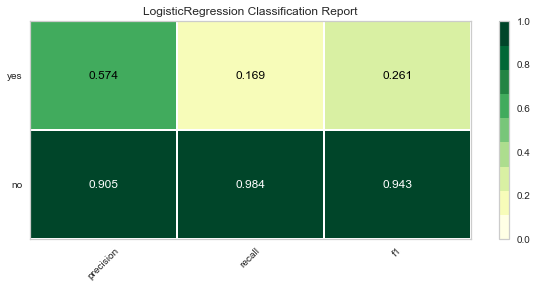

In [101]:
show_classification_rpt(logit)

In [102]:
print(classification_report(y_test, y_pred_logit))

              precision    recall  f1-score   support

          no       0.90      0.98      0.94     14646
         yes       0.57      0.17      0.26      1830

    accuracy                           0.89     16476
   macro avg       0.74      0.58      0.60     16476
weighted avg       0.87      0.89      0.87     16476



In [103]:
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred_logit))

Confusion Matrix:
[[14417   229]
 [ 1521   309]]


## Decision Tree

In [104]:
tree = DecisionTreeClassifier(random_state=rand_state)

In [105]:
print("Accuracy with Decision Tree", end=': ')
y_pred_tree = fit_predict(tree, X_train, X_test, y_train, y_test)
tree_accuracy = accuracy_score(y_test, y_pred_tree)
print(tree_accuracy)

Accuracy with Decision Tree: 0.8491138625880068


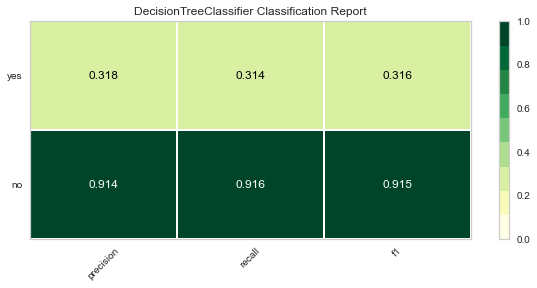

In [106]:
show_classification_rpt(tree)

In [107]:
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred_tree))

Confusion Matrix:
[[13416  1230]
 [ 1256   574]]


### Hyper Parameter Tuning

In [108]:
def fit_predict_dt(train, test, y_train, y_test, scaler, max_depth,
               criterion = 'entropy', max_features=1, min_samples_split=4):
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    dt = DecisionTreeClassifier(criterion = criterion, max_depth=max_depth,
                               random_state= 101, max_features=max_features,
                               min_samples_split=min_samples_split)
    dt.fit(train_scaled, y_train)
    y_pred = dt.predict(test_scaled)
    return y_pred

### Max depth parameter tuning

In [109]:
list_max_depth = []

In [110]:
for i in range(1,30):
    print("Accuracy score using max_depth = ", i, end = ':')
    y_pred_tree_hpt = fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), i)
    dt_max_depth = accuracy_score(y_test, y_pred_tree_hpt)
    print(dt_max_depth)
    list_max_depth.append(dt_max_depth)
    
max_depth_tuned = list_max_depth.index(max(list_max_depth))+1
print(max_depth_tuned)

Accuracy score using max_depth =  1:0.8889293517844137
Accuracy score using max_depth =  2:0.8889900461277009
Accuracy score using max_depth =  3:0.8897790725904345
Accuracy score using max_depth =  4:0.8897790725904345
Accuracy score using max_depth =  5:0.8887472687545521
Accuracy score using max_depth =  6:0.889900461277009
Accuracy score using max_depth =  7:0.8880189366351056
Accuracy score using max_depth =  8:0.8931779558145181
Accuracy score using max_depth =  9:0.8911750424860403
Accuracy score using max_depth =  10:0.8903253216800194
Accuracy score using max_depth =  11:0.8903860160233066
Accuracy score using max_depth =  12:0.891357125515902
Accuracy score using max_depth =  13:0.8891721291575625
Accuracy score using max_depth =  14:0.88814032532168
Accuracy score using max_depth =  15:0.8893542121874242
Accuracy score using max_depth =  16:0.8845593590677349
Accuracy score using max_depth =  17:0.8862588006797767
Accuracy score using max_depth =  18:0.8866836610827871
Accur

### Max features tuning

In [111]:
dict_max_features = {}

In [112]:
for i in np.arange(0.1,1.0,0.1):
    print('Accuracy score using max features =', i, end = ":")
    y_pred_max_features = fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features=i)
    dt_max_features = accuracy_score(y_test, y_pred_max_features)
    print(dt_max_features)
    dict_max_features[i]=dt_max_features

max_feature_tuned = max(dict_max_features, key=dict_max_features.get)
print(max_feature_tuned)

Accuracy score using max features = 0.1:0.8919033746054867
Accuracy score using max features = 0.2:0.8972444768147608
Accuracy score using max features = 0.30000000000000004:0.901128914785142
Accuracy score using max features = 0.4:0.8996115562029618
Accuracy score using max features = 0.5:0.8996722505462491
Accuracy score using max features = 0.6:0.8983369749939306
Accuracy score using max features = 0.7000000000000001:0.9001578052925467
Accuracy score using max features = 0.8:0.9005826656955572
Accuracy score using max features = 0.9:0.8998543335761107
0.30000000000000004


### Min samples split tuning

In [113]:
dict_min_samples_split = {}

In [114]:
for i in range(2,10):
    print('Accuracy score using min samples split=', i, end=":")
    y_pred_min_split = fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features=max_feature_tuned, min_samples_split=i)
    dt_min_sample_split = accuracy_score(y_test, y_pred_min_split)
    print(dt_min_sample_split)
    dict_min_samples_split[i] = dt_min_sample_split
    
min_sample_split_tuned = max(dict_min_samples_split, key=dict_min_samples_split.get)
print(min_sample_split_tuned)

Accuracy score using min samples split= 2:0.8950594804564215
Accuracy score using min samples split= 3:0.8950594804564215
Accuracy score using min samples split= 4:0.901128914785142
Accuracy score using min samples split= 5:0.901128914785142
Accuracy score using min samples split= 6:0.8954236465161447
Accuracy score using min samples split= 7:0.898458363680505
Accuracy score using min samples split= 8:0.8967589220684632
Accuracy score using min samples split= 9:0.8973051711580481
4


### Criterion tuning

In [115]:
dict_index_tuned = {}

In [116]:
for i in ['gini','entropy']:
    print("Accuracy score using criterion: ", i, end = ':')
    y_pred_index_score = fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features = max_feature_tuned, min_samples_split=min_sample_split_tuned, criterion= i)
    dt_index_score = accuracy_score(y_test, y_pred_index_score)
    print(dt_index_score)
    dict_index_tuned[i] = dt_index_score

dt_index_tuned = max(dict_index_tuned, key=dict_index_tuned.get)
print(dt_index_tuned)

Accuracy score using criterion:  gini:0.8973658655013352
Accuracy score using criterion:  entropy:0.901128914785142
entropy


### Rerunning decision tree with best parameters

In [117]:
tree_best_pred  =  fit_predict_dt(X_train, X_test, y_train, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features = max_feature_tuned, min_samples_split=min_sample_split_tuned, criterion= dt_index_tuned)
dt_best_param_score = accuracy_score(y_test, tree_best_pred)
print("Accuracy score for decision tree using best param: ", end = ':')
print(dt_best_param_score)

Accuracy score for decision tree using best param: :0.901128914785142


In [118]:
tree1 = DecisionTreeClassifier(criterion = dt_index_tuned, max_depth=max_depth_tuned,
                               random_state= rand_state, max_features=max_feature_tuned,
                               min_samples_split=min_sample_split_tuned)

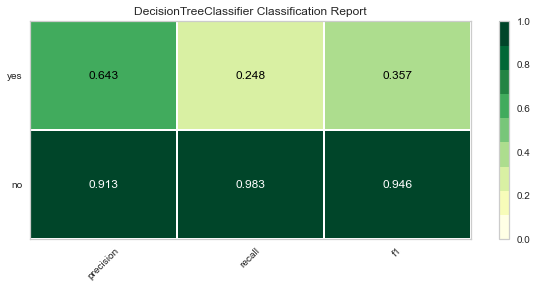

In [119]:
show_classification_rpt(tree1)

In [120]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, tree_best_pred))

Confusion Matrix:
[[14394   252]
 [ 1377   453]]


### Using polynomial features

In [121]:
def create_poly(train, test, degree):
    poly = PolynomialFeatures(degree = degree)
    train_poly = poly.fit_transform(train)
    test_poly = poly.fit_transform(test)
    return train_poly, test_poly

In [122]:
## polynomial features taking a lot of time as the number of columns are more. Hence commented the following piece of code

In [123]:
# for degree in [1,2,3,4]:
#     train_poly, test_poly = create_poly(X_train, X_test, degree)
#     print("polynomial degree", degree)
#     fit_predict(train_poly, test_poly, y_train, y_test, StandardScaler(), 16, max_features = 0.2,min_samples_split=4, criterion='entropy')
#     print(10 *'-')

## Random Forest

In [124]:
forest = RandomForestClassifier(criterion='entropy', oob_score=True)

In [125]:
print("Accuracy with Random Forest", end=': ')
rf_pred = fit_predict(forest, X_train, X_test, y_train, y_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(rf_accuracy)

Accuracy with Random Forest: 0.890203932993445


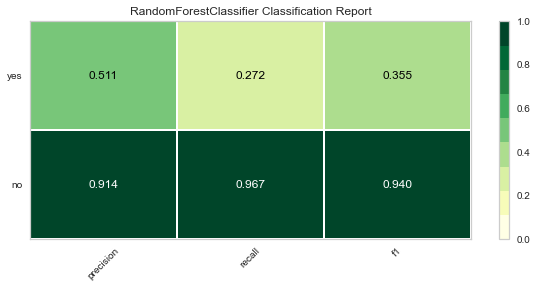

In [126]:
show_classification_rpt(forest)

In [127]:
print("Confusion Matrix:")
print(confusion_matrix(y_test,rf_pred))

Confusion Matrix:
[[14169   477]
 [ 1332   498]]


### Parameter tuning using Grid Search

In [128]:
params = {
    'n_estimators': [200,500,700],
    'max_depth': [10,15,20,25],
    'min_samples_leaf': [3,5,7]
}

In [129]:
gs = GridSearchCV(forest, params, cv=cv, verbose=verbose, n_jobs=number_of_jobs)

In [130]:
if grid_search_enable == True:
    gs.fit(X_train, y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  7.8min finished


In [131]:
if grid_search_enable == True:
    print(gs.best_params_)

{'max_depth': 15, 'min_samples_leaf': 7, 'n_estimators': 700}


In [132]:
if grid_search_enable == True:
    forest_best_max_depth = gs.best_params_['max_depth']
    forest_best_min_samples = gs.best_params_['min_samples_leaf']
    forest_best_n_estimators = gs.best_params_['n_estimators']
    #forest_best_criterion = gs.best_params_['criterion']

In [133]:
if grid_search_enable == True:
    print(gs.best_estimator_)

RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=7,
                       n_estimators=700, oob_score=True)


### Retraining with best estimators

In [134]:
if grid_search_enable == True:
    forest1 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=forest_best_max_depth, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=forest_best_min_samples, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=forest_best_n_estimators,
                       n_jobs=number_of_jobs, oob_score=True, random_state=rand_state,
                       verbose=0, warm_start=False)

In [135]:
if grid_search_enable == True:
    forest1.fit(X_train, y_train)

In [136]:
if grid_search_enable == True:
    pred_forest1 = forest1.predict(X_test)

In [137]:
if grid_search_enable == True:
    print("Accuracy with Random Forest after Hyper Parameter Tuning", end=': ')
    rf_hyper_accuracy = accuracy_score(y_test, pred_forest1)
    print(rf_hyper_accuracy)

Accuracy with Random Forest after Hyper Parameter Tuning: 0.9012503034717164


In [138]:
if grid_search_enable == True:
    for x in sorted(list(zip(forest1.feature_importances_, X_train.columns)), reverse=True):
        print(x)

(0.0918651287049599, 'euribor3m')
(0.07371689847831699, 'f.interest_rate')
(0.05839435907671573, 'f.recession_strength_non-peak')
(0.05494926807934635, 'f.recession_strength_peak')
(0.035828825675949236, 'f.year_Y2008')
(0.03348092415985964, 'f.euribor1_lt_1')
(0.024805002506533128, 'f.euribor1_gt_4')
(0.023668117772236555, 'f.income')
(0.020338522924334378, 'poutcome_failure')
(0.01988070021942443, 'poutcome_success')
(0.0176215987704, 'f.emp_var_rate_negative')
(0.017026157869707067, 'f.emp_var_rate_positive')
(0.016139939061733836, 'f.emp.var.bin_gt_1')
(0.01550767026901794, 'f.year_Y2010')
(0.014571998301347734, 'f.pattern_no')
(0.010604922910539674, 'contact_cellular')
(0.009740112166231964, 'f.age_to_retire_weight')
(0.009735444351233753, 'contact_telephone')
(0.008647798210528964, 'f.week_breakup_week_mid')
(0.008585149502148653, 'f.savings_intent_factor')
(0.00810426751716814, 'month_may')
(0.008059557270707847, 'f.year_Y2009')
(0.00784050912009229, 'previous')
(0.0075501731348

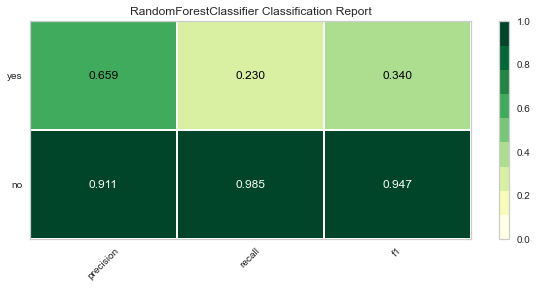

In [139]:
if grid_search_enable == True:
    show_classification_rpt(forest1)

In [140]:
if grid_search_enable == True:
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, pred_forest1))

Confusion Matrix:
[[14429   217]
 [ 1410   420]]


## Accuracy Summary Without Boosting

In [141]:
print("Accuracy with Logistic Regression", end=': ')
print(logit_accuracy)
print("Accuracy with Decision Tree", end=': ')
print(tree_accuracy)
print("Accuracy of Decision Tree after Hyper Parameter Tuning: ", end = ':')
print(dt_best_param_score)
print("Accuracy with Random Forest", end=': ')
print(rf_accuracy)
if grid_search_enable == True:
    print("Accuracy with Random Forest after Hyper Parameter Tuning", end=': ')
    print(rf_hyper_accuracy)

Accuracy with Logistic Regression: 0.8937848992473901
Accuracy with Decision Tree: 0.8491138625880068
Accuracy of Decision Tree after Hyper Parameter Tuning: :0.901128914785142
Accuracy with Random Forest: 0.890203932993445
Accuracy with Random Forest after Hyper Parameter Tuning: 0.9012503034717164


## AdaBoost

In [142]:
from sklearn.ensemble import AdaBoostClassifier

In [143]:
adabst_fit = AdaBoostClassifier(base_estimator=logit, random_state=rand_state, n_estimators=100)

In [144]:
adabst_fit.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=LogisticRegression(), n_estimators=100,
                   random_state=101)

In [145]:
print("Accuracy with Ada Boost", end=': ')
ada_boost_predict = adabst_fit.predict(X_test)
ada_boost_accuracy = accuracy_score(y_test,ada_boost_predict)
print(ada_boost_accuracy)

Accuracy with Ada Boost: 0.8917212915756252


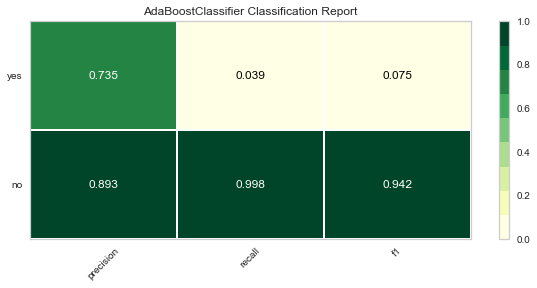

In [146]:
show_classification_rpt(adabst_fit)

In [147]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, ada_boost_predict))

Confusion Matrix:
[[14620    26]
 [ 1758    72]]


### Adaboost with Grid Search

In [148]:
params_adaboost = {
    'n_estimators': [100,200,300],
    'base_estimator': [logit, tree1],
    'learning_rate': [0.5,0.75,1.0]
}

In [149]:
ada_gs = GridSearchCV(adabst_fit, params_adaboost, cv=cv, n_jobs=number_of_jobs)

In [150]:
if grid_search_enable == True:
    ada_gs.fit(X_train, y_train)

In [151]:
if grid_search_enable == True:
    adabst_best_estimator = ada_gs.best_params_['base_estimator']
    adabst_best_learning_rate = ada_gs.best_params_['learning_rate']
    adabst_best_n_estimators = ada_gs.best_params_['n_estimators']

In [152]:
if grid_search_enable == True:
    ada_gs.best_params_

### Adaboost - Retraining with best estimators

In [153]:
if grid_search_enable == True:
    ada_best = AdaBoostClassifier(base_estimator=adabst_best_estimator, random_state=rand_state,
                                  n_estimators=adabst_best_n_estimators, learning_rate=adabst_best_learning_rate)

In [154]:
if grid_search_enable == True:
    ada_best.fit(X_train, y_train)
    ada_best_predict = ada_best.predict(X_test)

In [155]:
if grid_search_enable == True:
    print("Accuracy with Adaboost after Hyper Parameter Tuning", end=': ')
    ada_best_hyper_accuracy = accuracy_score(y_test, ada_best_predict)
    print(ada_best_hyper_accuracy)

Accuracy with Adaboost after Hyper Parameter Tuning: 0.8957271182325808


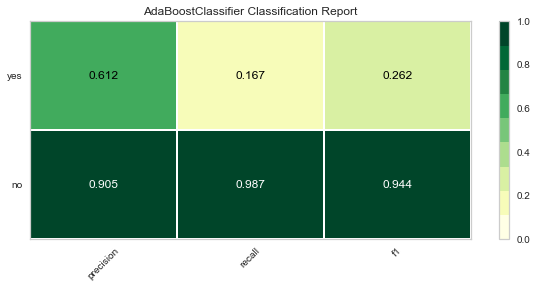

In [156]:
if grid_search_enable == True:
    show_classification_rpt(ada_best)

In [157]:
if grid_search_enable == True:
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, ada_best_predict))

Confusion Matrix:
[[14453   193]
 [ 1525   305]]


## Gradient Boost

In [158]:
from sklearn.ensemble import GradientBoostingClassifier

In [159]:
gbc_fit = GradientBoostingClassifier(n_estimators=500,
                                     min_samples_split=2,min_samples_leaf=1,max_depth=1,random_state=rand_state)

In [160]:
gbc_fit.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=1, n_estimators=500, random_state=101)

In [161]:
print("Accuracy with Gradient Boost", end=': ')
y_pred_gbc = gbc_fit.predict(X_test)
gbc_accuracy = accuracy_score(y_test, y_pred_gbc)
print(gbc_accuracy)

Accuracy with Gradient Boost: 0.8993080844865259


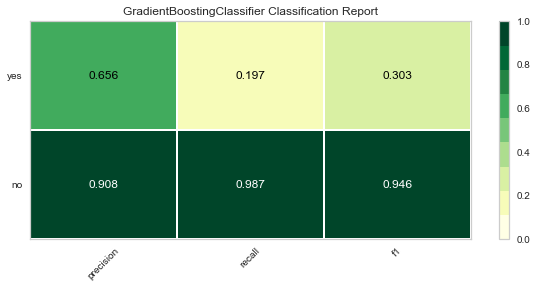

In [162]:
show_classification_rpt(gbc_fit)

In [163]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gbc))

Confusion Matrix:
[[14457   189]
 [ 1470   360]]


### Gradient boost with Grid Search

In [164]:
params_gbc = {
    'n_estimators': [100,300,500],
    'max_depth': [2,3,4],
    'learning_rate': [0.05,0.075,0.1]
}

In [165]:
gbc_gs = GridSearchCV(gbc_fit, params_gbc, cv=cv, n_jobs=number_of_jobs)

In [166]:
if grid_search_enable == True:
    gbc_gs.fit(X_train, y_train)

In [167]:
if grid_search_enable == True:
    gbc_best_estimator = gbc_gs.best_params_['n_estimators']
    gbc_best_max_depth = gbc_gs.best_params_['max_depth']
    gbc_best_learning_rate = gbc_gs.best_params_['learning_rate']

In [168]:
if grid_search_enable == True:
    print(gbc_gs.best_params_)

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


### Gradient Boost - With Best Parameters

In [169]:
if grid_search_enable == True:
    gbc_best = GradientBoostingClassifier(n_estimators=gbc_best_estimator,
                                     min_samples_split=2,min_samples_leaf=1,max_depth=gbc_best_max_depth,random_state=rand_state,
                                         learning_rate=gbc_best_learning_rate)

In [170]:
if grid_search_enable == True:
    gbc_best.fit(X_train, y_train)
    gbc_best_predict = gbc_best.predict(X_test)

In [171]:
if grid_search_enable == True:
    print("Accuracy with Gradient Boost after Hyper Parameter Tuning", end=': ')
    gbc_best_hyper_accuracy = accuracy_score(y_test, gbc_best_predict)
    print(gbc_best_hyper_accuracy)

Accuracy with Gradient Boost after Hyper Parameter Tuning: 0.9015537751881525


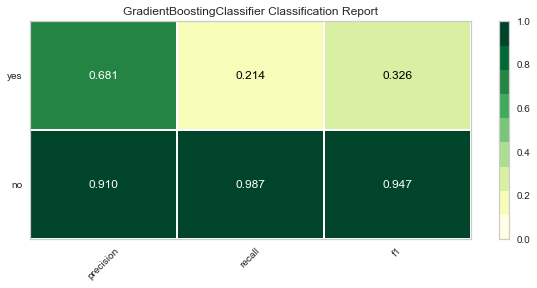

In [172]:
if grid_search_enable == True:
    show_classification_rpt(gbc_best)

In [173]:
if grid_search_enable == True:
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, gbc_best_predict))

Confusion Matrix:
[[14462   184]
 [ 1438   392]]


## LGBM

In [174]:
from lightgbm import LGBMClassifier

In [175]:
LGBM = LGBMClassifier(n_jobs=number_of_jobs, num_leaves=31)
LGBM.fit(X_train, y_train)

LGBMClassifier()

In [176]:
LGBM_predict = LGBM.predict(X_test)

In [177]:
print("Accuracy with LGBM", end=': ')
lgbm_accuracy = accuracy_score(y_test,LGBM_predict)
print(lgbm_accuracy)

Accuracy with LGBM: 0.9002184996358339


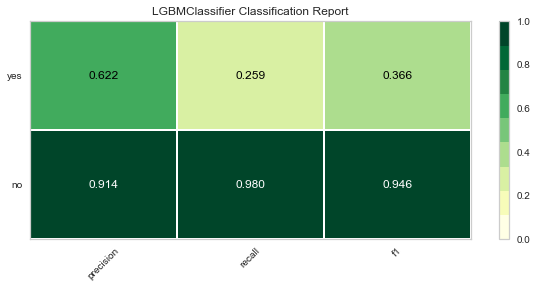

In [178]:
show_classification_rpt(LGBM)

In [179]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, LGBM_predict))

Confusion Matrix:
[[14358   288]
 [ 1356   474]]


### LGBM With Grid Search

In [180]:
lgbm_params = {
    'num_leaves': [31,35,41,45],
    'n_estimators': [50,75,100,150]
}

In [181]:
if grid_search_enable == True:
    lgbm_gs = GridSearchCV(LGBM, lgbm_params, cv=cv, n_jobs=number_of_jobs)
    lgbm_gs.fit(X_train, y_train)

In [182]:
if grid_search_enable == True:
    lgbm_best_estimator = lgbm_gs.best_params_['n_estimators']
    lgbm_best_num_leaves = lgbm_gs.best_params_['num_leaves']
    print(lgbm_gs.best_params_)

{'n_estimators': 75, 'num_leaves': 31}


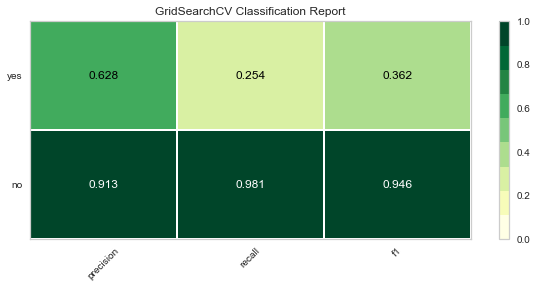

In [183]:
if grid_search_enable == True:
    show_classification_rpt(lgbm_gs)

### LGBM With Best Parameters

In [184]:
if grid_search_enable == True:
    LGBM_best = LGBMClassifier(n_jobs=number_of_jobs, num_leaves=lgbm_best_num_leaves, 
                               n_estimators=lgbm_best_estimator)
    LGBM_best.fit(X_train, y_train)

In [185]:
if grid_search_enable == True:
    LGBM_best_predict = LGBM_best.predict(X_test)
    LGBM_accuracy_score = accuracy_score(y_test,LGBM_best_predict)

In [186]:
if grid_search_enable == True:
    print("Accuracy with LGBM with Hyper Parameter Tuning", end=': ')
    print(LGBM_accuracy_score)

Accuracy with LGBM with Hyper Parameter Tuning: 0.9004005826656956


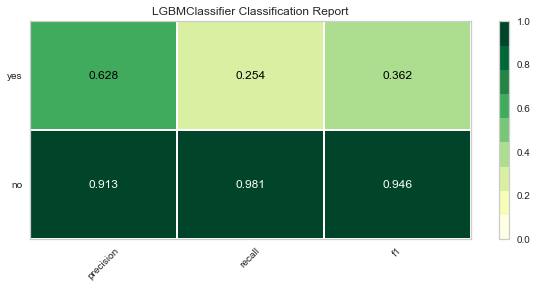

In [187]:
if grid_search_enable == True:
    show_classification_rpt(LGBM_best)

In [188]:
if grid_search_enable == True:
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, LGBM_best_predict))

Confusion Matrix:
[[14370   276]
 [ 1365   465]]


## XG Boost

In [189]:
from xgboost import XGBClassifier

In [190]:
xgb_fit = XGBClassifier(max_depth=2, n_estimators=5000, random_state=rand_state, n_jobs=number_of_jobs)
xgb_fit.fit(X_train, y_train)

XGBClassifier(max_depth=2, n_estimators=5000, n_jobs=-1, random_state=101)

In [191]:
print("Accuracy with XG Boost", end=': ')
xgb_predict = xgb_fit.predict(X_test)
xgb_accuracy = accuracy_score(y_test,xgb_predict)
print(xgb_accuracy)

Accuracy with XG Boost: 0.8968196164117505


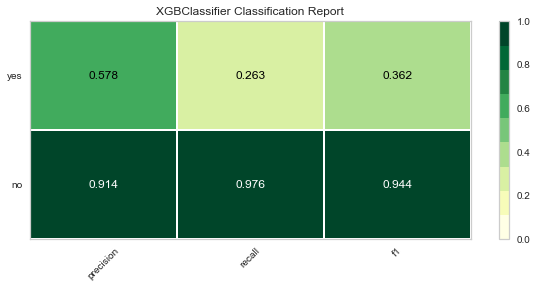

In [192]:
show_classification_rpt(xgb_fit)

In [193]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, xgb_predict))

Confusion Matrix:
[[14294   352]
 [ 1348   482]]


### XG Boost with Grid Search

In [194]:
xgb_params = {
    'max_depth': [2,3,4],
    'n_estimators': [300,500,700],
    'learning_rate': [0.05,0.075,0.1]
}

In [195]:
xgb_gs = GridSearchCV(xgb_fit, xgb_params, cv=cv, n_jobs=number_of_jobs)

In [196]:
if grid_search_enable == True:
    xgb_gs.fit(X_train, y_train)

In [197]:
if grid_search_enable == True:
    print(xgb_gs.best_params_)

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}


In [198]:
if grid_search_enable == True:
    xgb_best_max_depth = xgb_gs.best_params_['max_depth']
    xgb_best_n_estimators = xgb_gs.best_params_['n_estimators']
    xgb_best_learning_rate = xgb_gs.best_params_['learning_rate']

### Re-running XG Boost with Best Parameters

In [199]:
if grid_search_enable == True:
    xgb_best = XGBClassifier(max_depth=xgb_best_max_depth,
                             n_estimators=xgb_best_n_estimators, random_state=rand_state,
                             n_jobs=number_of_jobs, learning_rate = xgb_best_learning_rate)
    xgb_best.fit(X_train, y_train)
    xgb_best_predict = xgb_best.predict(X_test)

In [200]:
if grid_search_enable == True:
    print("Accuracy with XG Boost after Hyper Parameter Tuning", end=': ')
    xgb_best_hyper_accuracy = accuracy_score(y_test, xgb_best_predict)
    print(xgb_best_hyper_accuracy)

Accuracy with XG Boost after Hyper Parameter Tuning: 0.9013109978150037


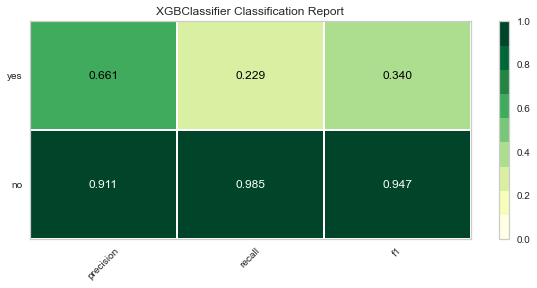

In [201]:
if grid_search_enable == True:
    show_classification_rpt(xgb_best)

In [202]:
if grid_search_enable == True:
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, xgb_best_predict))

Confusion Matrix:
[[14431   215]
 [ 1411   419]]


## Accuracy Summary With Boosting

In [203]:
print("Accuracy with Logistic Regression", end=': ')
print(logit_accuracy)

print("Accuracy with Decision Tree", end=': ')
print(tree_accuracy)
print("Accuracy with Decision Tree after Hyper Parameter Tuning: ", end = ':')
print(dt_best_param_score)

print("Accuracy with Random Forest", end=': ')
print(rf_accuracy)
if grid_search_enable == True:
    print("Accuracy with Random Forest after Hyper Parameter Tuning", end=': ')
    print(rf_hyper_accuracy)

print("Accuracy with Ada Boost", end=': ')
print(ada_boost_accuracy)
if grid_search_enable == True:
    print("Accuracy with Ada Boost after Hyper Parameter Tuning", end=': ')
    print(ada_best_hyper_accuracy)

print("Accuracy with Gradient Boost", end=': ')
print(gbc_accuracy)
if grid_search_enable == True:
    print("Accuracy with Gradient Boost after Hyper Parameter Tuning", end=': ')
    print(gbc_best_hyper_accuracy)
    
print("Accuracy with LGBM", end=': ')
print(lgbm_accuracy)
if grid_search_enable == True:
    print("Accuracy with LGBM after Hyper Parameter Tuning", end=': ')
    print(LGBM_accuracy_score)
    
print("Accuracy with XG Boost", end=': ')
print(xgb_accuracy)
if grid_search_enable == True:
    print("Accuracy with XG Boost after Hyper Parameter Tuning", end=': ')
    print(xgb_best_hyper_accuracy)

Accuracy with Logistic Regression: 0.8937848992473901
Accuracy with Decision Tree: 0.8491138625880068
Accuracy with Decision Tree after Hyper Parameter Tuning: :0.901128914785142
Accuracy with Random Forest: 0.890203932993445
Accuracy with Random Forest after Hyper Parameter Tuning: 0.9012503034717164
Accuracy with Ada Boost: 0.8917212915756252
Accuracy with Ada Boost after Hyper Parameter Tuning: 0.8957271182325808
Accuracy with Gradient Boost: 0.8993080844865259
Accuracy with Gradient Boost after Hyper Parameter Tuning: 0.9015537751881525
Accuracy with LGBM: 0.9002184996358339
Accuracy with LGBM after Hyper Parameter Tuning: 0.9004005826656956
Accuracy with XG Boost: 0.8968196164117505
Accuracy with XG Boost after Hyper Parameter Tuning: 0.9013109978150037


## Optimization Using Voting Classifiers

In [204]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

In [208]:
estimators = []
estimators.append(('tree', tree))
estimators.append(('dtree-hpt', tree1))
estimators.append(('randomforest', forest1))
estimators.append(('gradient', gbc_best))
estimators.append(('lgbm', LGBM))
estimators.append(('xgboost', xgb_best))
ensemble = VotingClassifier(estimators, voting='soft', weights=[1,2,2,2,2,2])
#results = cross_val_score(ensemble, X, y, cv=5, scoring='accuracy', )
#print(results.mean())
ensemble.fit(X_train, y_train)
y_pred1 = ensemble.predict(X_test)
print(accuracy_score(y_test, y_pred1))

0.9020393299344501


### Max accuracy with Random Forest after Hyper Parameter Tuning: 0.9019786355911629

### Confusion Matrix:
[[14454   192]
 [ 1423   407]]